In [70]:
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore') #https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Authentication
consumerKey = "Your Consumer Key"
consumerSecret = "Your Consumer Secret"
accessToken = "Your Access Token"
accessTokenSecret = "Your Access Token Secret"

auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

In [3]:
print ('API Host', api.auth.OAUTH_HOST)
print ('API Version', api.auth.OAUTH_ROOT)

API Host api.twitter.com
API Version /oauth/


In [24]:
pd.set_option('display.max_colwidth', None)
search_term = 'Covid 19'

tweets = tweepy.Cursor(api.search_tweets,
                       q=search_term,
                       lang="en").items(100)

retrieved_tweets = [tweet._json for tweet in tweets]
df = pd.json_normalize(retrieved_tweets)
df[['text']].sample(3)

,text
62,RT @Reuters: South Korea said it will drop all operating-hour curbs on restaurants and cafes and implement its first vaccine passport for h…
41,"RT @Cleavon_MD: 🇧🇷 7 day old Matheus from Rio Claro, São Paulo #Brazil developed trouble breathing 2 days following birth &amp; passed away fro…"
12,"RT @Cleavon_MD: 🇺🇸 15 y.o. Dykota Morgan, athlete and honor student from Bolingbrook #Illinois died from COVID on May 4, 2021. Dykota had a…"


In [4]:
api = tweepy.API(auth,
                 wait_on_rate_limit=True,
                 retry_count=5,
                 retry_delay=10)

search_term = 'Covid 19 OR Corona Virus -filter:retweets'

tweets = tweepy.Cursor(api.search_tweets,
                       q=search_term,
                       lang="en",
                       tweet_mode='extended',
                       count=30).items(100)

retrieved_tweets = [tweet._json for tweet in tweets]

df = pd.json_normalize(retrieved_tweets)
print('Number of retrieved tweets ', len(df))

Number of retrieved tweets  100


In [5]:
df[['created_at','full_text','entities.hashtags']].sample(2)

,created_at,full_text,entities.hashtags
64,Fri Oct 29 00:20:54 +0000 2021,Perfect example of how dumb it all is and how unrealistic everyone is. They caught a contagious virus and someone got it way worse than others. If this had been Norwalk they would not be blaming the rink https://t.co/Zx5vbJDQCz,[]
5,Fri Oct 29 01:58:11 +0000 2021,Can't wait for HC's approval of pediatric COVID 19 vaccination. I don't want my kids to get exposed to this virus without protection of the mask and highly effective vaccine. This is a blessing! ❤️ science...,[]


In [6]:
def extract_entities(entity_list):
    entities = set()
    if len(entity_list) != 0:
        for item in entity_list:
            for key,value in item.items():
                if key == 'text':
                    entities.add(value.lower())
    return list(entities)

<AxesSubplot:title={'center':'Covid@Twitter'}>

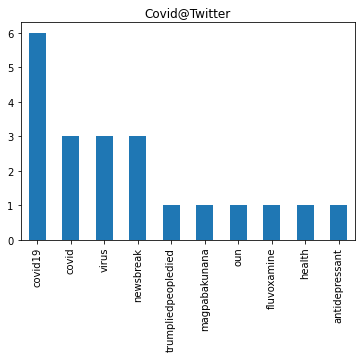

In [7]:
df['Entities'] = df['entities.hashtags'].apply(extract_entities)
pd.Series(np.concatenate(df['Entities'])).value_counts()[:10].plot(kind='bar', title="Covid@Twitter")


In [10]:
text = " ".join(review for review in df['text'])
print ("Total Number of Words in all Reviews: {}".format(len(text)))

Total Number of Words in all Reviews: 13407


In [11]:
wordcloud = WordCloud(background_color="white").generate(text)

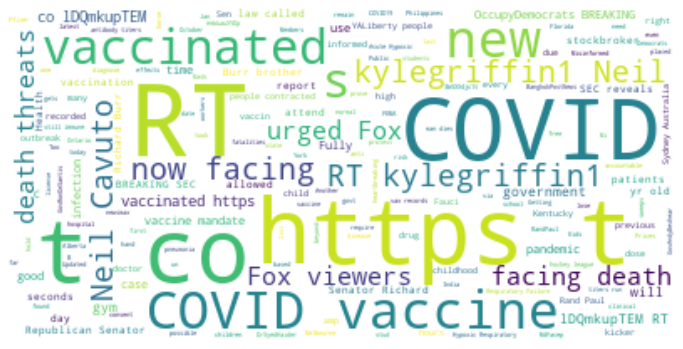

In [12]:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

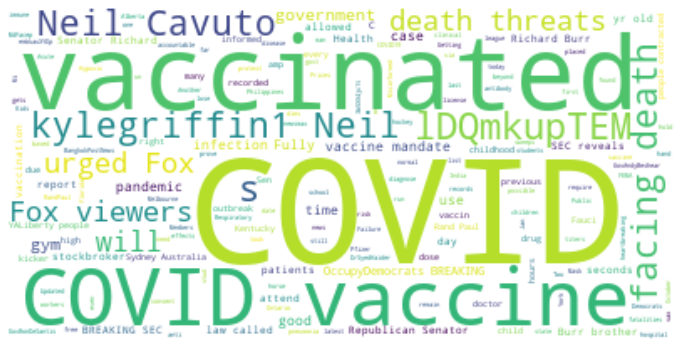

In [13]:
stopwords = set(STOPWORDS)

stopwords.update(["now", "new", "media", "supervisor", "https", "RT", "t", "co"])

wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
sentiment_objects = [TextBlob(tweet) for tweet in df['text']]

In [15]:
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

In [57]:
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

sentiment_df.head()

,polarity,tweet
0,0.000000,RT @UHhospitals: Who is currently eligible for COVID-19 vaccine boosters? Use the below infographic as a guide and visit https://t.co/KZroE…
1,0.062500,"RT @ntfcovid19ph: The Philippines achieved a major milestone in its vaccination program on Thursday, October 28, with the arrival of the 10…"
2,0.700000,RT @GoodNew71069432: @RandPaul Good news is: Rand Paul is all but an expert on Covid: He recommended horse deworming drugs as a cure for Co…
3,0.000000,RT @townhallcom: Two Doctors Detail Being Silenced Over Their Views on COVID-19 Mask Mandates and Vaccines https://t.co/3J7GmnXU7w
4,0.136667,"RT @yoojminie: from high schooler jimin with her phone case from the marymond brand, supporting comfort women victims and human rights to a…"


In [55]:
sentiment_df = sentiment_df[sentiment_df.polarity != 0]

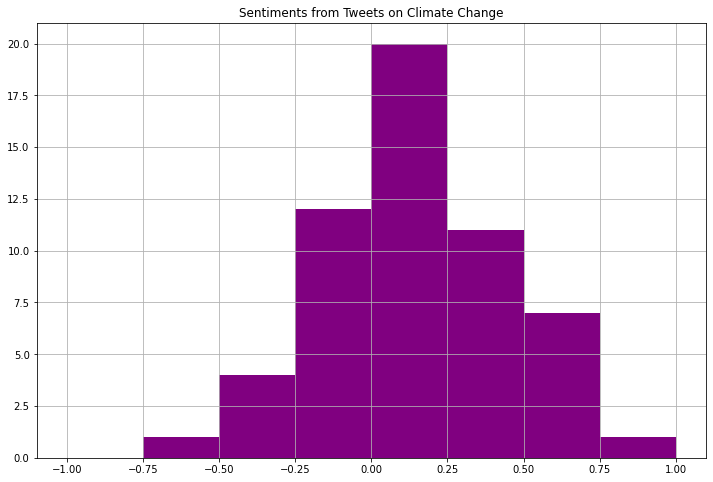

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Climate Change")
plt.show()

In [58]:
feature_vector = sentiment_df['tweet']

In [59]:
processed_features = []

for sentence in range(0, len(feature_vector)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(feature_vector[sentence]))

    # Remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [60]:
#https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524

def getAnalysis(score):
  if score < 0:
    return "Negative"
  elif score == 0:
    return "Neutral"
  else:
    return "Positive"

In [61]:
sentiment_df['sentiment'] = sentiment_df['polarity'].apply(getAnalysis)

In [62]:
labels = sentiment_df['sentiment'].values
print(labels)

['Neutral' 'Positive' 'Positive' 'Neutral' 'Positive' 'Neutral' 'Positive'
 'Neutral' 'Positive' 'Negative' 'Positive' 'Neutral' 'Neutral' 'Positive'
 'Neutral' 'Neutral' 'Neutral' 'Negative' 'Negative' 'Neutral' 'Negative'
 'Positive' 'Negative' 'Negative' 'Positive' 'Negative' 'Neutral'
 'Positive' 'Negative' 'Neutral' 'Neutral' 'Neutral' 'Neutral' 'Positive'
 'Neutral' 'Positive' 'Positive' 'Neutral' 'Positive' 'Negative'
 'Positive' 'Neutral' 'Neutral' 'Negative' 'Positive' 'Neutral' 'Positive'
 'Positive' 'Positive' 'Positive' 'Negative' 'Positive' 'Neutral'
 'Neutral' 'Neutral' 'Neutral' 'Neutral' 'Positive' 'Neutral' 'Neutral'
 'Neutral' 'Positive' 'Positive' 'Positive' 'Positive' 'Negative'
 'Neutral' 'Negative' 'Neutral' 'Positive' 'Negative' 'Positive' 'Neutral'
 'Positive' 'Positive' 'Negative' 'Negative' 'Positive' 'Neutral'
 'Positive' 'Neutral' 'Neutral' 'Positive' 'Negative' 'Neutral' 'Neutral'
 'Positive' 'Neutral' 'Positive' 'Neutral' 'Neutral' 'Neutral' 'Positive'
 'N

In [63]:
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))

In [64]:
processed_features_vec = vectorizer.fit_transform(processed_features).toarray()

In [65]:
X_train, X_test, y_train, y_test = train_test_split(processed_features_vec, labels, test_size=0.2, random_state=0)

In [66]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [67]:
predictions = text_classifier.predict(X_test)

In [71]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("Accuracy {0:.2f}%".format(100*accuracy_score(y_test, predictions)))

[[0 0 2]
 [0 6 4]
 [0 3 5]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         2
     Neutral       0.67      0.60      0.63        10
    Positive       0.45      0.62      0.53         8

    accuracy                           0.55        20
   macro avg       0.37      0.41      0.39        20
weighted avg       0.52      0.55      0.53        20

Accuracy 55.00%


In [69]:
# Obtain a test sample text from our test dataset

for i in range(0,5):
  rand_index = np.random.randint(0,len(processed_features))
  test_sample = processed_features[rand_index]
  print(test_sample)

  # Try our classifer on our text
  vector = vectorizer.transform([test_sample])
  output = text_classifier.predict(vector.toarray())
  print("Sentiment is - " + str(output[0]) + "\n")

rt jeremy_nolais the health minister doesn know how many surgeries have been cancelled as result of his government horrendous failu 
Sentiment is - Positive

panda webinar for students 31 october 16 30 https co rtaptgxnu3 in light of the lack of informed consent https co tb5gcdp1gn
Sentiment is - Neutral

rt christinapushaw in florida there will be no covid 19 vaccine mandate on schoolchildren that is the law govrondesantis
Sentiment is - Neutral

rt newsmax sen rand paul democrats won hold fauci accountable but will https co emwuauxydp https co 3w5xx4jc1t
Sentiment is - Neutral

sa announces covid 19 roadmap including repeal of border restrictions on november 23 https co b4gicauw3a https co wbtmvrv6il
Sentiment is - Positive

